<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<h3>(1) Collect data to which applying an autoregression might make sense. Explain why autoregression might be a good fit for the data. Use an AR(1) and and an AR(optimal) model to predict the data and display the original data and predicted values in a time series chart. Check if the AIC and BIC criteria both result in the same number of lags for the AR(optimal) model.</h3>

#### Why use gold price for autoregression?
The reason why I thought it might make sense to use the price of gold from 2014-2025 is due to a couple of reasons. Firstly, it's in a time series format and it came from MCX Live which tracks the price of Gold, Zinc, Silver, Crude Oil, Natural Gas, etc... Secondly, short-term autocorrelation is possibly prevalent since when gold prices rise it isn't a one off sharp increase. It will do so gradually and then level out. Same goes for when gold decreases. So this menas there may be a short window of learning that an autoregressive model may learn from. Finally I thought it would be an interesting topic to look into because the online buzz is to "buy gold" because it is stable. So perhaps with this study we can find out how stable gold is.

There might be a need to take a difference from the data if the data looks to random, and because there are definitley exogenous regressors out there that impact the price of gold, this model isn't reliable on it's own.

Gold Price Source: https://mcxlive.org/gold/

Dataset Source: https://www.kaggle.com/datasets/nisargchodavadiya/daily-gold-price-20152021-time-series/data

In [28]:
# TODO Import python libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [29]:
# read in gold, and also convert everything into usd since it was indian ruppess.

df = pd.read_csv('../datasets/gold_price.csv')
df.head(5)
df.info()
# it only tracks the business days which makes sense I guess. keep that in mind for when I set the cadence or horizon I guess.
# Prices are in INR (Indian Rupee) for 10gm of Gold 24K.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2848 non-null   object 
 1   Price   2848 non-null   int64  
 2   Open    2848 non-null   int64  
 3   High    2848 non-null   int64  
 4   Low     2848 non-null   int64  
 5   Volume  2848 non-null   int64  
 6   Chg%    2848 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 155.9+ KB


In [30]:
import pandas as pd

def convert_gold_prices_to_usd(df, usd_inr_rate=84.0):
    """
    Convert gold price DataFrame from INR to USD using a fixed exchange rate.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with columns: Date, Price, Open, High, Low, Volume, Chg%
    usd_inr_rate : float
        USD/INR exchange rate (default: 84.0, i.e., 1 USD = 84 INR)
    
    Returns:
    --------
    pandas DataFrame with prices converted to USD
    """
    # Create a copy to avoid modifying original
    df_usd = df.copy()
    
    # Convert Date to datetime if not already
    df_usd['Date'] = pd.to_datetime(df_usd['Date'])
    
    # Convert price columns from INR to USD
    price_columns = ['Price', 'Open', 'High', 'Low']
    for col in price_columns:
        df_usd[col] = (df_usd[col] / usd_inr_rate).round(2)
    
    # Display summary
    print(f"Conversion complete using rate: 1 USD = {usd_inr_rate} INR")
    print(f"Total records converted: {len(df_usd)}")
    print(f"\nPrice Statistics (USD):")
    print(f"  Mean: ${df_usd['Price'].mean():.2f}")
    print(f"  Min:  ${df_usd['Price'].min():.2f}")
    print(f"  Max:  ${df_usd['Price'].max():.2f}")
    print(f"\nFirst 5 rows:")
    print(df_usd[['Date', 'Price', 'Open', 'High', 'Low']].head())
    
    return df_usd

In [31]:
# Assuming your DataFrame is named 'df'
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)

# For autoregression modeling:
df_usd = df_usd.sort_values('Date').reset_index(drop=True)
prices = df_usd['Price'].values # this is my target and the variable i'll be using lags with.

Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67


In [32]:
df_usd.tail(15)
# Prices are in USD $ for 10gm of Gold 24K.

,Date,Price,Open,High,Low,Volume,Chg%
2833,2024-12-16,910.55,910.71,914.99,908.93,13730,-0.14
2834,2024-12-17,908.50,911.46,911.73,903.95,15200,-0.22
2835,2024-12-18,906.13,907.92,910.30,904.89,11000,-0.26
2836,2024-12-19,895.13,898.81,903.94,892.95,19350,-1.21
2837,2024-12-20,902.21,895.24,905.06,893.69,16059,0.79
2838,2024-12-23,898.88,900.95,904.33,897.05,14200,-0.37
2839,2024-12-24,899.55,900.30,901.05,897.90,10820,0.07
2840,2024-12-26,906.12,903.19,907.14,901.90,9730,0.73
2841,2024-12-27,902.18,906.67,910.06,900.73,15260,-0.43
2842,2024-12-30,899.01,898.13,910.12,896.86,10260,-0.35


In [33]:
# i really only want price since I will use previous price dates for help with the predictions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error


# Helper function to fit ar models using price.
def fit_ar_models(df_usd, max_lags=20, train_split=0.8):
    """
    Fit AR(1) and AR(optimal) models to gold price data
    
    Parameters:
    -----------
    df_usd : DataFrame with USD prices
    max_lags : maximum lags to consider for optimal model
    train_split : proportion of data for training
    
    Returns:
    --------
    Dictionary with models, predictions, and metrics
    """
    # Sort by date and prepare data
    df_sorted = df_usd.sort_values('Date').reset_index(drop=True) # very important for time series.
    prices = df_sorted['Price'].values
    dates = df_sorted['Date'].values
    
    # Split into train and test
    train_size = int(len(prices) * train_split)
    train_data = prices[:train_size]
    test_data = prices[train_size:]
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]
    
    print("="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Total observations: {len(prices)}")
    print(f"Training set: {len(train_data)} observations")
    print(f"Test set: {len(test_data)} observations")
    print(f"Date range: {dates[0]} to {dates[-1]}")
    
    # Find optimal lag order using AIC and BIC
    print("\n" + "="*60)
    print("SELECTING OPTIMAL LAG ORDER")
    print("="*60)
    
    selection = ar_select_order(train_data, maxlag=max_lags, ic='aic')
    optimal_lag_aic = selection.ar_lags[-1] if len(selection.ar_lags) > 0 else 1
    
    selection_bic = ar_select_order(train_data, maxlag=max_lags, ic='bic')
    optimal_lag_bic = selection_bic.ar_lags[-1] if len(selection_bic.ar_lags) > 0 else 1
    
    print(f"Optimal lag by AIC: {optimal_lag_aic}")
    print(f"Optimal lag by BIC: {optimal_lag_bic}")
    
    if optimal_lag_aic == optimal_lag_bic:
        print(f"✓ AIC and BIC agree on optimal lag: {optimal_lag_aic}")
    else:
        print(f"✗ AIC and BIC disagree (AIC: {optimal_lag_aic}, BIC: {optimal_lag_bic})")
        print(f"  Using AIC selection: {optimal_lag_aic}")
    
    optimal_lag = optimal_lag_aic
    
    # Fit AR(1) model
    print("\n" + "="*60)
    print("FITTING AR(1) MODEL")
    print("="*60)
    ar1_model = AutoReg(train_data, lags=1, trend='c')
    ar1_fitted = ar1_model.fit()
    print(ar1_fitted.summary())
    
    # Fit AR(optimal) model
    print("\n" + "="*60)
    print(f"FITTING AR({optimal_lag}) MODEL")
    print("="*60)
    ar_opt_model = AutoReg(train_data, lags=optimal_lag, trend='c')
    ar_opt_fitted = ar_opt_model.fit()
    print(ar_opt_fitted.summary())
    
    # Make predictions on test set
    ar1_predictions = ar1_fitted.predict(start=len(train_data), 
                                         end=len(train_data) + len(test_data) - 1)
    ar_opt_predictions = ar_opt_fitted.predict(start=len(train_data), 
                                               end=len(train_data) + len(test_data) - 1)
    
    # Calculate MSE
    mse_ar1 = mean_squared_error(test_data, ar1_predictions)
    mse_ar_opt = mean_squared_error(test_data, ar_opt_predictions)
    
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    print(f"AR(1) Model:")
    print(f"  AIC: {ar1_fitted.aic:.2f}")
    print(f"  BIC: {ar1_fitted.bic:.2f}")
    print(f"  Test MSE: {mse_ar1:.4f}")
    print(f"  Test RMSE: {np.sqrt(mse_ar1):.4f}")
    
    print(f"\nAR({optimal_lag}) Model:")
    print(f"  AIC: {ar_opt_fitted.aic:.2f}")
    print(f"  BIC: {ar_opt_fitted.bic:.2f}")
    print(f"  Test MSE: {mse_ar_opt:.4f}")
    print(f"  Test RMSE: {np.sqrt(mse_ar_opt):.4f}")
    
    # Return results
    results = {
        'dates': dates,
        'prices': prices,
        'train_dates': train_dates,
        'test_dates': test_dates,
        'train_data': train_data,
        'test_data': test_data,
        'ar1_fitted': ar1_fitted,
        'ar_opt_fitted': ar_opt_fitted,
        'ar1_predictions': ar1_predictions,
        'ar_opt_predictions': ar_opt_predictions,
        'optimal_lag_aic': optimal_lag_aic,
        'optimal_lag_bic': optimal_lag_bic,
        'optimal_lag': optimal_lag,
        'mse_ar1': mse_ar1,
        'mse_ar_opt': mse_ar_opt
    }
    
    return results

# Step 3: Visualize results
def plot_results(results):
    """Create time series plots comparing models"""
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: AR(1) Model
    ax1 = axes[0]
    ax1.plot(results['dates'], results['prices'], 
             label='Original Data', color='black', linewidth=1.5, alpha=0.7)
    ax1.plot(results['test_dates'], results['ar1_predictions'], 
             label='AR(1) Predictions', color='red', linewidth=2, linestyle='--')
    ax1.axvline(x=results['train_dates'][-1], color='gray', 
                linestyle=':', linewidth=2, label='Train/Test Split')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Gold Price (USD)', fontsize=12)
    ax1.set_title(f'AR(1) Model - Test RMSE: ${np.sqrt(results["mse_ar1"]):.2f}', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: AR(optimal) Model
    ax2 = axes[1]
    ax2.plot(results['dates'], results['prices'], 
             label='Original Data', color='black', linewidth=1.5, alpha=0.7)
    ax2.plot(results['test_dates'], results['ar_opt_predictions'], 
             label=f'AR({results["optimal_lag"]}) Predictions', 
             color='blue', linewidth=2, linestyle='--')
    ax2.axvline(x=results['train_dates'][-1], color='gray', 
                linestyle=':', linewidth=2, label='Train/Test Split')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Gold Price (USD)', fontsize=12)
    ax2.set_title(f'AR({results["optimal_lag"]}) Model - Test RMSE: ${np.sqrt(results["mse_ar_opt"]):.2f}', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final comparison
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    if results['optimal_lag_aic'] == results['optimal_lag_bic']:
        print(f"✓ AIC and BIC both selected {results['optimal_lag']} lags")
    else:
        print(f"✗ AIC selected {results['optimal_lag_aic']} lags, BIC selected {results['optimal_lag_bic']} lags")



Conversion complete using rate: 1 USD = 84.0 INR
Total records converted: 2848

Price Statistics (USD):
  Mean: $490.74
  Min:  $292.20
  Max:  $943.54

First 5 rows:
        Date   Price    Open    High     Low
0 2025-01-06  918.44  920.35  923.12  911.25
1 2025-01-03  914.44  919.60  935.71  912.06
2 2025-01-02  914.87  914.87  914.87  914.87
3 2025-01-01  907.31  907.52  908.36  905.39
4 2024-12-31  907.52  900.95  916.31  899.67
DATA SUMMARY
Total observations: 2848
Training set: 2278 observations
Test set: 570 observations
Date range: 2014-01-01T00:00:00.000000000 to 2025-01-06T00:00:00.000000000

SELECTING OPTIMAL LAG ORDER
Optimal lag by AIC: 15
Optimal lag by BIC: 1
✗ AIC and BIC disagree (AIC: 15, BIC: 1)
  Using AIC selection: 15

FITTING AR(1) MODEL
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2278
Model:                     AutoReg(1)   Log Likelihood               -6

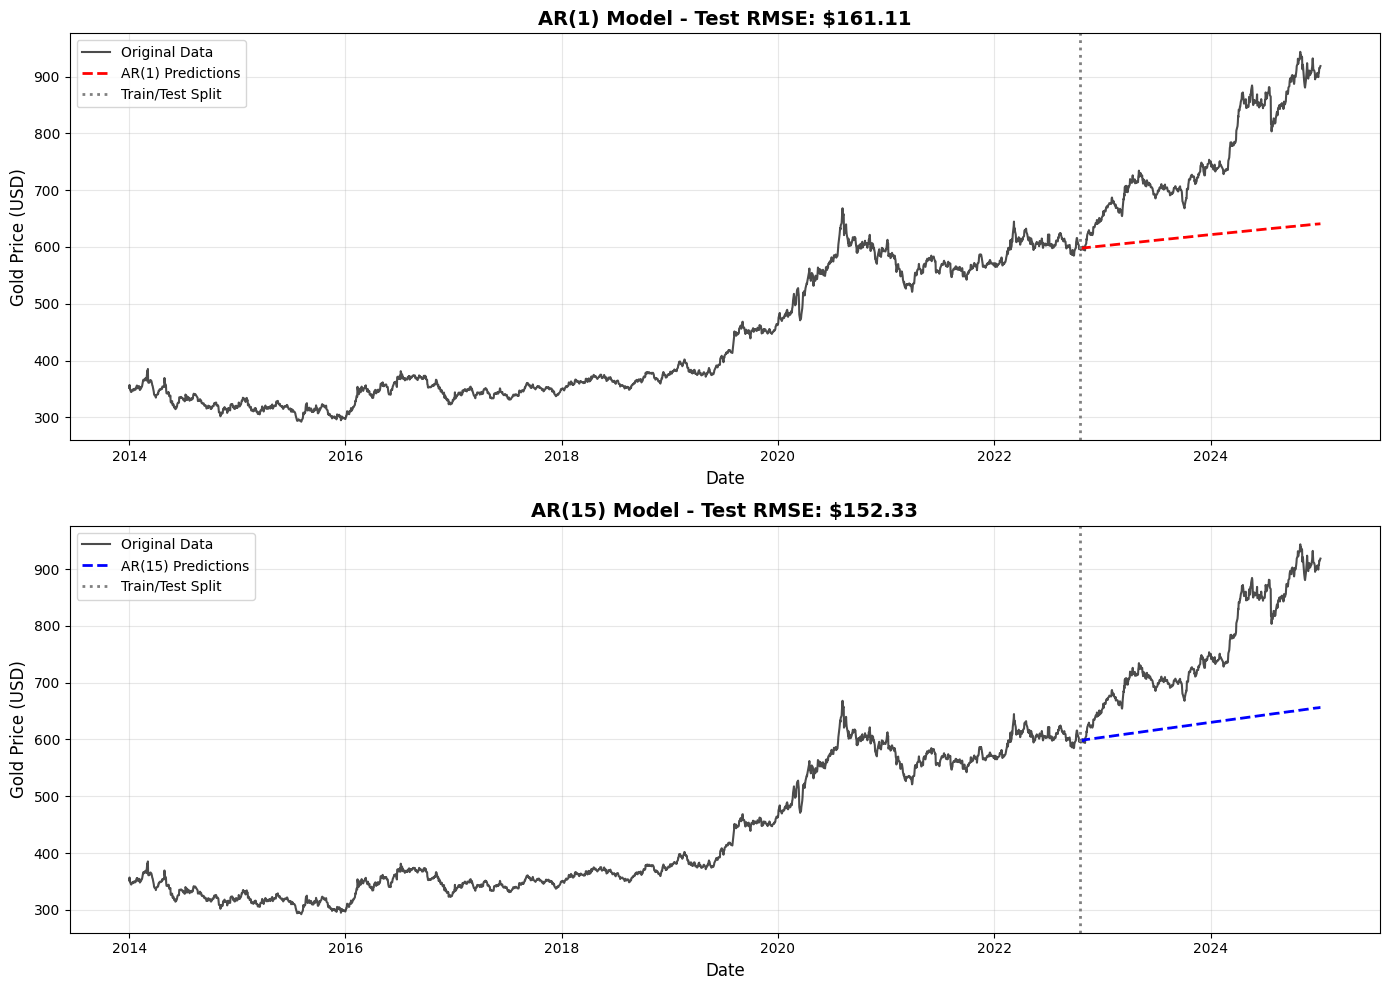


FINAL SUMMARY
✗ AIC selected 15 lags, BIC selected 1 lags


In [34]:
df_usd = convert_gold_prices_to_usd(df, usd_inr_rate=84.0)

results = fit_ar_models(df_usd, max_lags=20, train_split=0.8)

plot_results(results)

It did awful. Gonna try again with the first diff.

<h3>(2) Hide the end of the data set and forecast the series using the different models. Decide which model you would use and explain why.</h3>

In [35]:
# TODO 

<h3>(3) Add one other independent variable to the model and compare the forecasts of this updated model to the previous ones.</h3>

In [36]:
# TODO